# Introduction

Welcome to our 'WineNot?' GitHub Repository! This project serves as an educational resource for individuals interested in learning fundamental coding concepts using Python. Whether you’re a beginner or an experienced programmer, this repository aims to provide clarity on some data science structures and strategies.

# Importing the necessary libraries

In [34]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import kurtosis, skew
from scipy import stats
import sys
from wordcloud import WordCloud, STOPWORDS
#RGB List

# #820000 = Maroon 
# #4E6C50 = Sage
# #F2DEBA = Beige
# #FAECD6 = lighter Beige

# #86B6F6 = light blue
# #89CFF3 = sky blue
# #4CCD99 = teal

# Importing dataset

In [11]:
#To run the code, you need to insert the path where the dataset is saved into the brackets.
df_wine1 = pd.read_csv('/Users/samuelbohn/Library/Mobile Documents/com~apple~CloudDocs/WineNot_Techlabs/TechLabsDUS_WineNot/data/raw/winemag-data-130k-v2.csv', index_col=0)

# Cleaning the data

The following change of countrynames is essential for working with the geopandas library

In [12]:

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_merged = world.merge(df_wine1, how='left', left_on='name', right_on='country')
unrecognized_countries = df_wine1[~df_wine1['country'].isin(world_merged['country'])]['country'].tolist()

L = [] 
for x in unrecognized_countries:
    if x in L:
        pass
    else:
        L.append(x)
print(L)

['US', 'Czech Republic', 'England', 'Bosnia and Herzegovina', 'Macedonia']


/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_42421/1993641958.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


The given countries do not match those in the library, so we need to change the names to match those used in the geopandas library.

In [13]:
replacements = {
    'US': 'United States of America',
    'Czech Republic': 'Czechia',
    'England': 'United Kingdom',
    'Bosnia and Herzegovina': 'Bosnia and Herzegovina',
    'Macedonia': 'North Macedonia'
}
df_wine1['country'] = df_wine1['country'].replace(replacements)

# Ausgabe des aktualisierten DataFrames
df_wine1.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,United States of America,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,United States of America,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,United States of America,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


# Overview

Now we can start with an overview of the dataset

In [14]:
def overview(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

In [15]:
overview(df_wine1)

Dataset Shape: (129971, 13)


,Name,dtypes,Missing,Uniques
0,country,object,63,43
1,description,object,0,119955
2,designation,object,37465,37979
3,points,int64,0,21
4,price,float64,8996,390
5,province,object,63,425
6,region_1,object,21247,1229
7,region_2,object,79460,17
8,taster_name,object,26244,19
9,taster_twitter_handle,object,31213,15


It can be observed that only two columns, the points and price columns, contain numerical values as entries. These will be further examined statistically for more detailed analysis.

In [16]:
df_wine1.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


The assigned scores, ranging from 80 to a maximum of 100, indicate that all wines included in this dataset are of high quality, falling within the top fifth of the given point rating. That's a noteworthy point for further analysis. The price exhibits a wide range, spanning from 4 to 3300 USD.

# Point Distribution

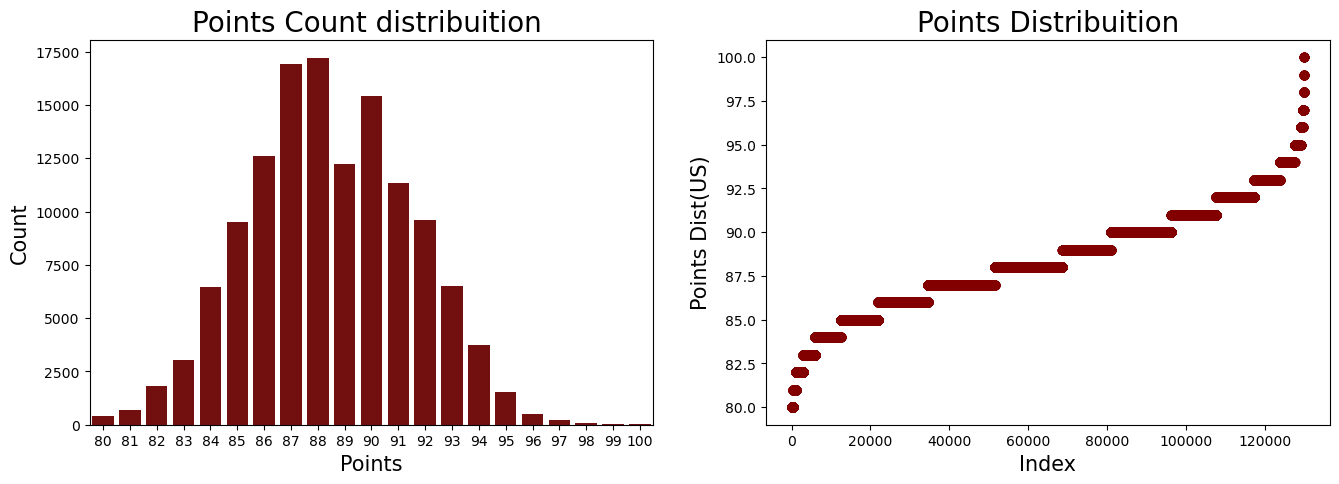

In [17]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
g = sns.countplot(x='points', data=df_wine1, color='#820000') 
g.set_title("Points Count distribuition ", fontsize=20) 
g.set_xlabel("Points", fontsize=15) 
g.set_ylabel("Count", fontsize=15) 

plt.subplot(1,2,2) 
plt.scatter(range(df_wine1.shape[0]), np.sort(df_wine1.points.values), color='#820000') 
plt.xlabel('Index', fontsize=15)  
plt.ylabel('Points Dist(US)', fontsize=15)  
plt.title("Points Distribuition", fontsize=20) 

plt.show() 

The data distribution is evident and appears to closely resemble a normal distribution. There is a limited number of wines with scores below 82 or above 95 points. Given the significance of points as a metric in this dataset, further exploration will be conducted.

# Price Distribution

Let's look into the price distribution as well!

A significant price difference is evident between the maximum and the first 75%. To visualize this, the price will be plotted against its frequency.

/Users/samuelbohn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


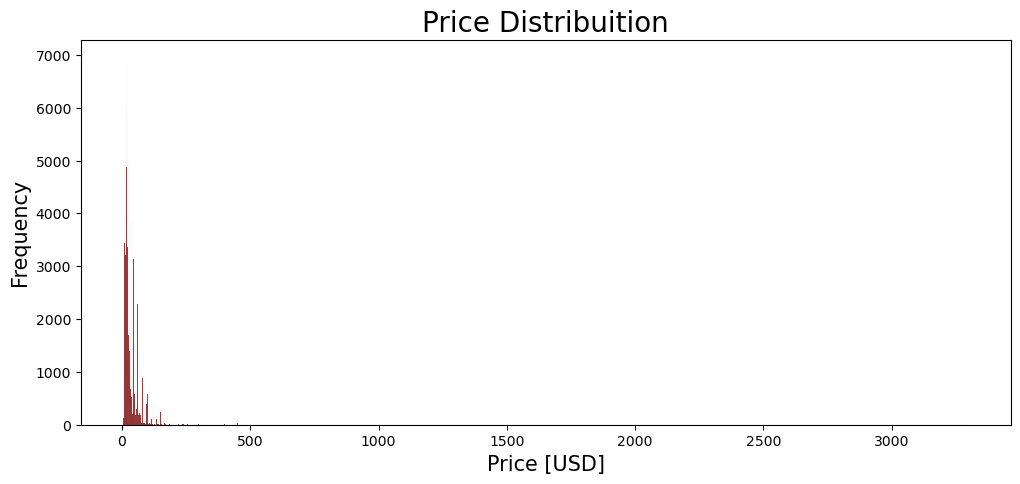

In [18]:
plt.figure(figsize=(12,5))

g = sns.histplot(df_wine1[df_wine1['price'].notnull()]['price'], color='#820000')
g.set_title("Price Distribuition", fontsize=20)
g.set_xlabel("Price [USD]", fontsize=15)
g.set_ylabel("Frequency", fontsize=15)


plt.show()

It's evident that almost all wines have a price below 200 USD. Let's further visualize this range for better clarity

/Users/samuelbohn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


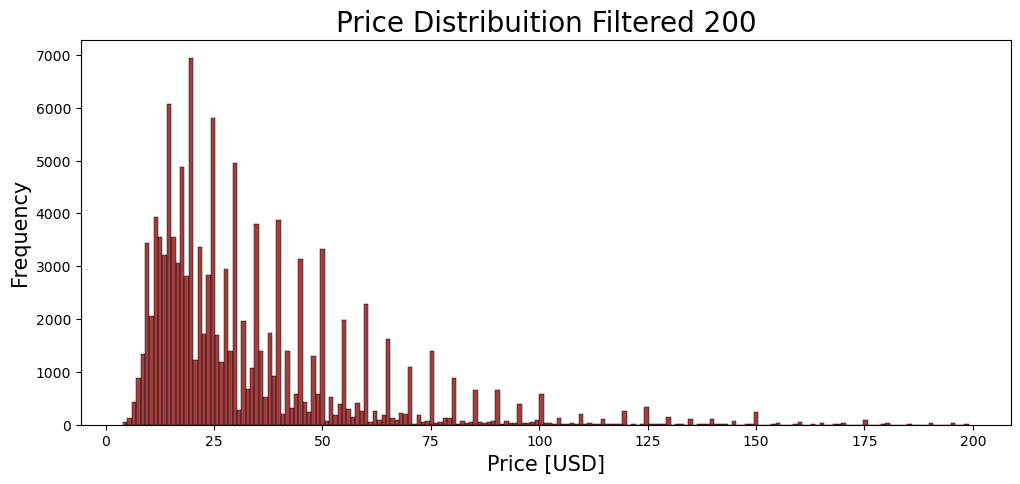

In [19]:
plt.figure(figsize=(12,5))

g = sns.histplot(df_wine1[df_wine1['price'] < 200]['price'], color='#820000')
g.set_title("Price Distribuition Filtered 200", fontsize=20)
g.set_xlabel("Price [USD]", fontsize=15)
g.set_ylabel("Frequency", fontsize=15)


plt.show()

From this graph, one could infer that it leans more towards a normal distribution.

# Country Feature

Let's start with an overview of all given countries

/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_42421/2177812151.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


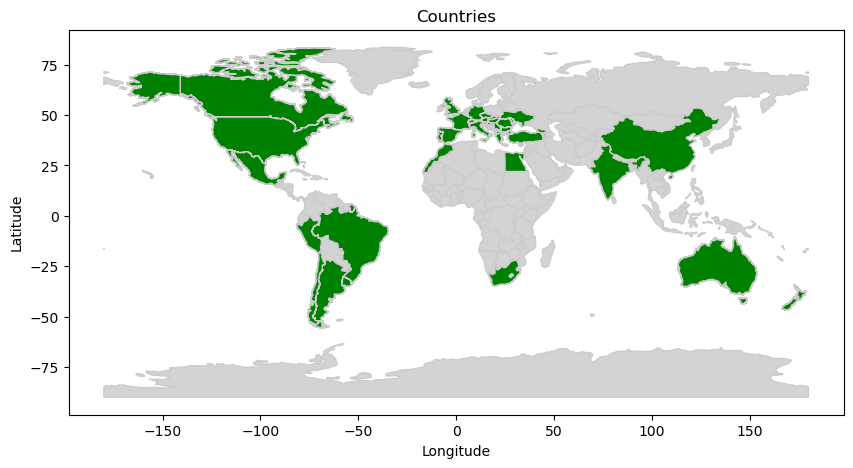

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_merged = world.merge(df_wine1, how='left', left_on='name', right_on='country')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world_merged.plot(ax=ax, color='lightgrey', edgecolor='0.8')
world_merged[world_merged['country'].notnull()].plot(ax=ax, color='green', edgecolor='0.8')
ax.set_title('Countries')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

One can observe that many American and European countries are present in the dataset, along with occasional African countries, as well as China, India, and Australia.

/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_42421/4264965777.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


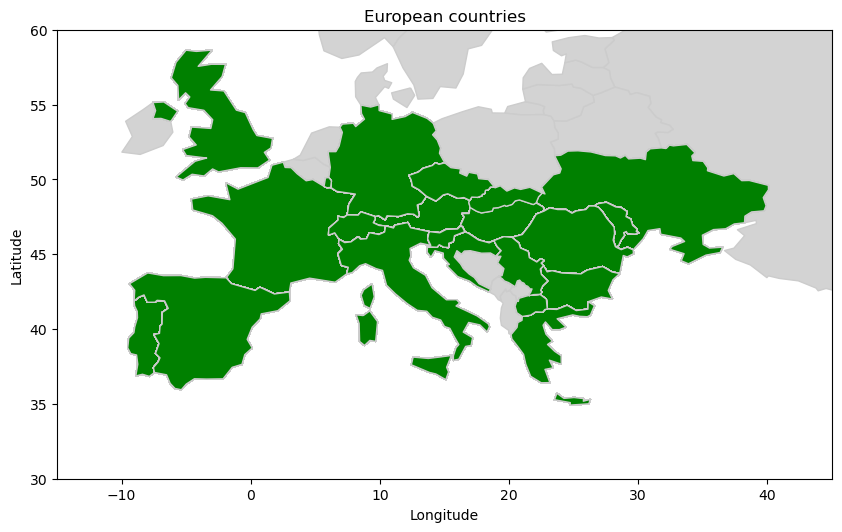

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
world_merged = europe.merge(df_wine1, how='left', left_on='name', right_on='country')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world_merged.plot(ax=ax, color='lightgrey', edgecolor='0.8')
world_merged[world_merged['country'].notnull()].plot(ax=ax, color='green', edgecolor='0.8')

ax.set_title('European countries')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

lat_min, lat_max = 30, 60
lon_min, lon_max = -15, 45

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

plt.show()

There is an huge amount of european countries in the dataset included!

Let's examine how many entries are available from each country in this dataset.
Therfore the following chart displays the counts of wines per country in the dataset. Only the top 25 countries are shown for an overview.

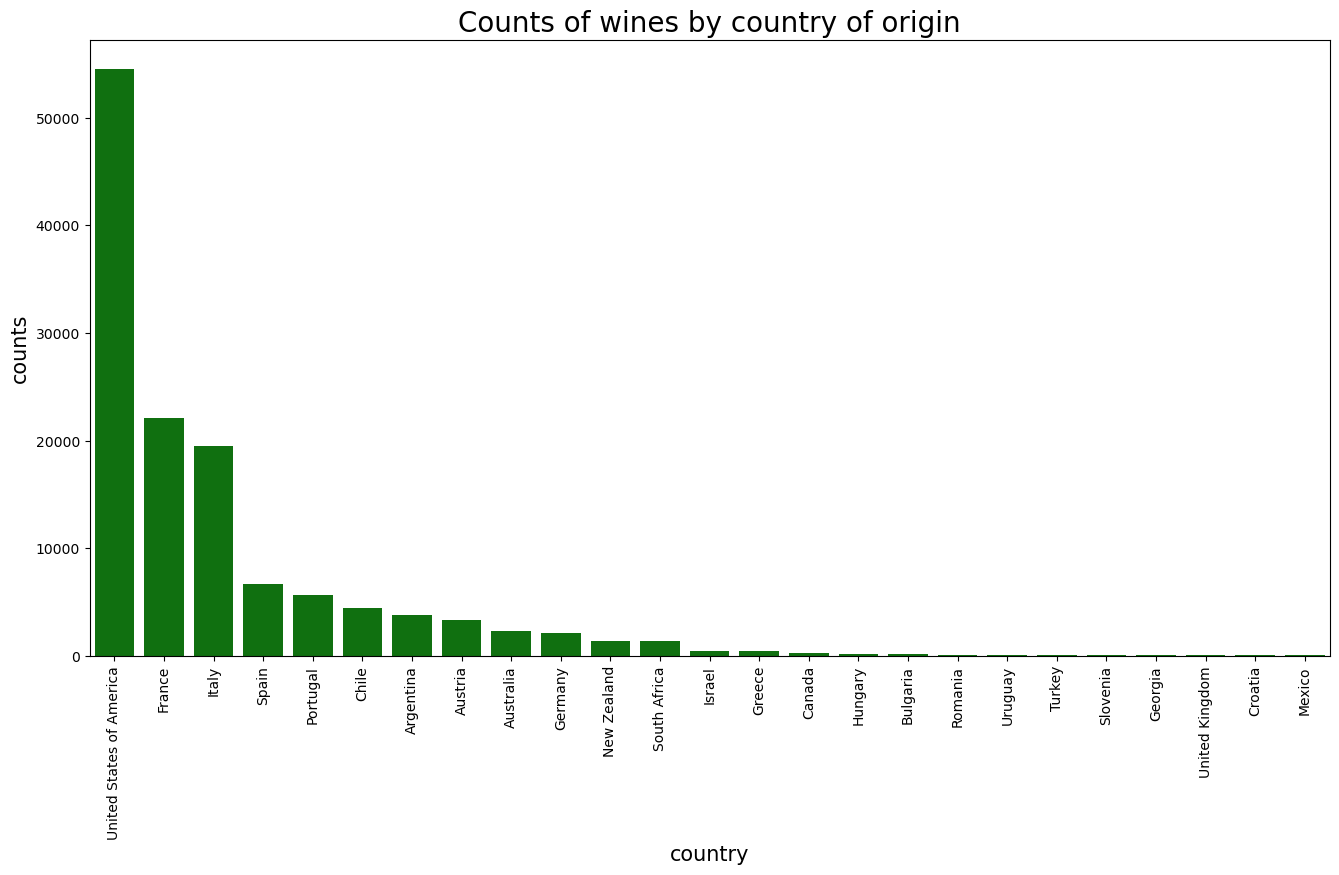

In [22]:
plt.figure(figsize=(16,8))

country = df_wine1.country.value_counts()[:25]

g = sns.countplot(x='country', 
                  data=df_wine1[df_wine1.country.isin(country.index.values)],
                 color='green', order=country.index)
g.set_title("Counts of wines by country of origin", fontsize=20)
g.set_xlabel("country", fontsize=15)
g.set_ylabel("counts", fontsize=15)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.show()

 It becomes evident that the country with the highest wine production (according to this dataset) are the United States of America. Additionally, the disparity between the highest and lowest producing countries is highlighted. This discrepancy can be attributed to various economic or political factors, as well as the overall size of the country.

To gain a more comprehensive understanding of the entire column, the following graph will also be included.

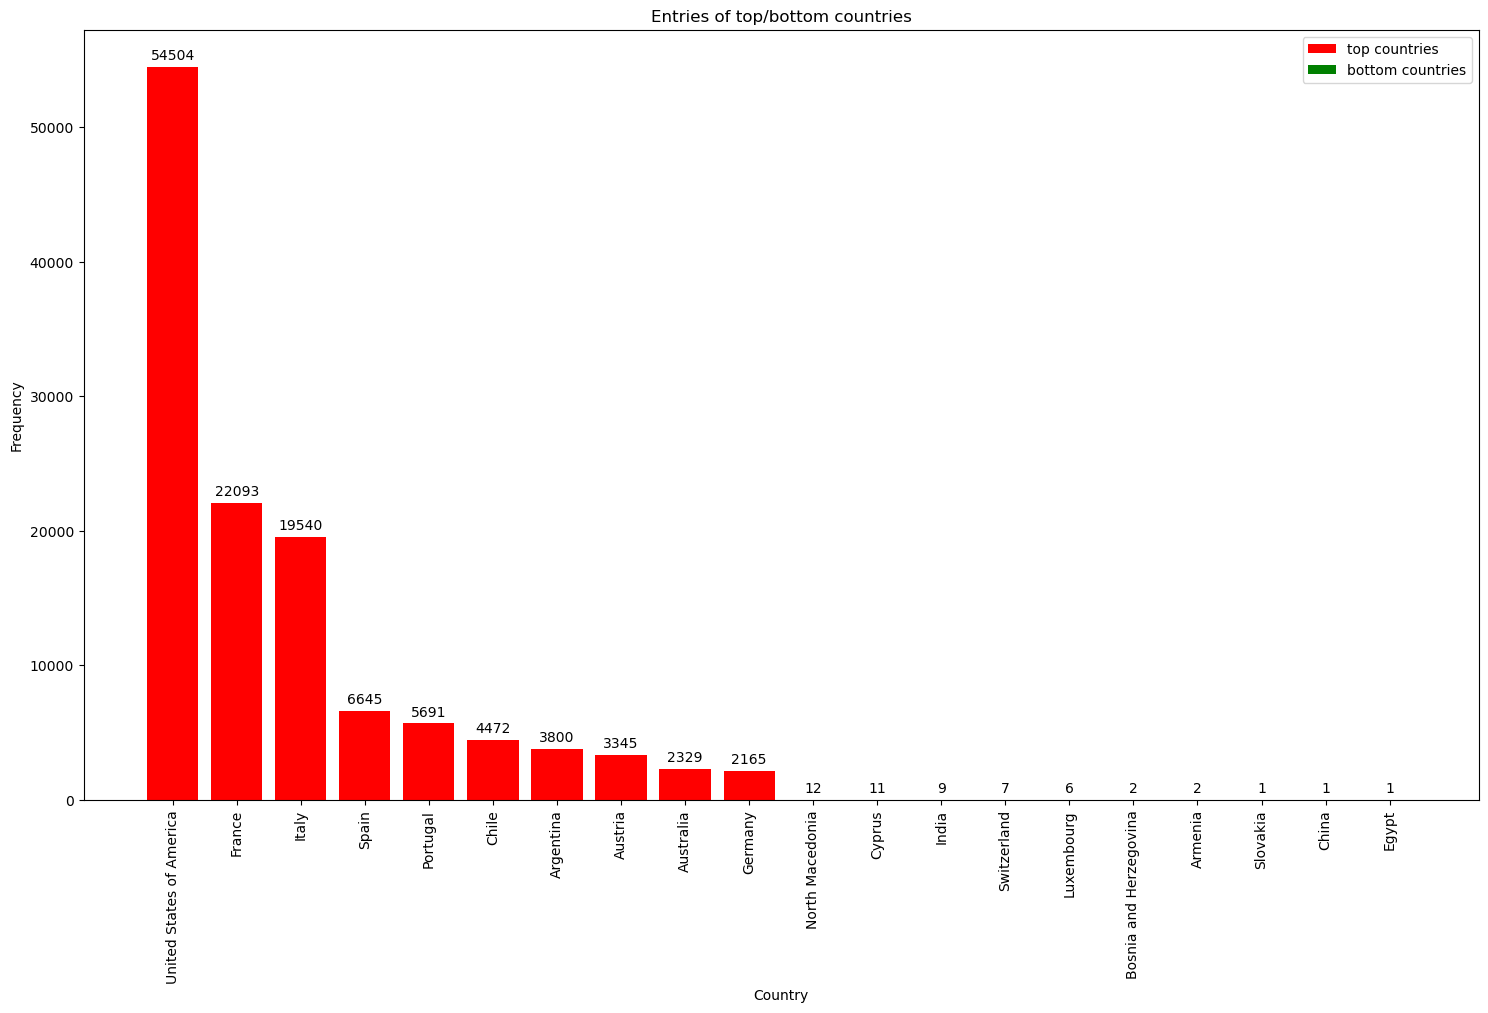

In [23]:
country_counts = df_wine1['country'].value_counts()
top_countries = country_counts.head(10)
bottom_countries = country_counts.tail(10)

def autolabel_freq(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.0f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, color='black')
plt.figure(figsize=(18, 10))
autolabel_freq(plt.bar(top_countries.index, top_countries.values, color='red', label='top countries'))
autolabel_freq(plt.bar(bottom_countries.index, bottom_countries.values, color='green', label='bottom countries'))
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('Entries of top/bottom countries')
plt.legend()
plt.xticks(rotation=90)
plt.show()

There are countries in the dataset that only have a single entry. With these countries, further analysis is not feasible.

# Point Distribution by Countries

The code below creates variable with mean points of wines in each country and then creates a map showing mean points of each country. This helps to compare average quality of wine in each country.

/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_42421/2490772286.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


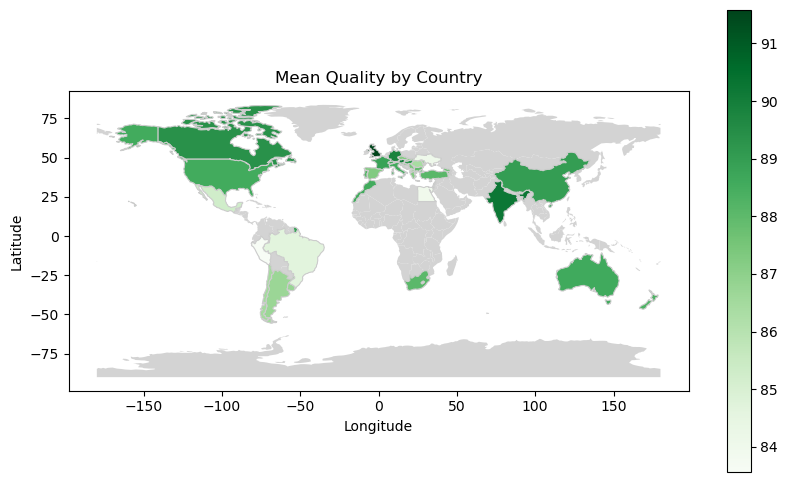

In [24]:
mean_points = df_wine1.groupby('country')['points'].mean().reset_index()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.merge(mean_points, how='left', left_on='name', right_on='country')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world.plot(ax=ax, color='lightgrey')
world.plot(column='points', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)


plt.title('Mean Quality by Country')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

For better representation, as done in the Country feature, the remaining countries have been shaded in gray.

In the next plot only the Europe results are presented for a more detailed country analysis. 

The wine could be valued higher because it's just a rare sort, so we see that United Kingdom has higher points but it also has much less wineries, compared to other Europe countries. So the rate could be subjective, as the sort could have not the best taste, but uncommon one. According to behavioural economic theory, people pay more attention to something that is not common and stands out. So this could be one of the reasons.

/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_42421/2843408885.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_42421/2843408885.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greens')


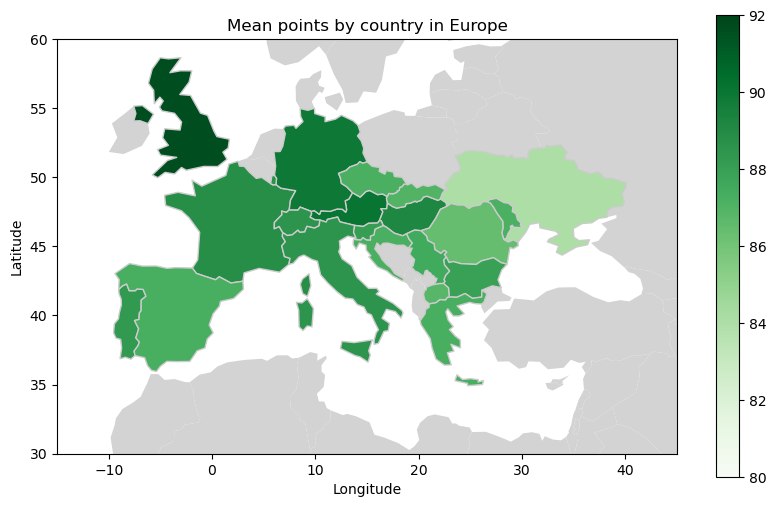

In [25]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

europe_with_mean_points = europe.merge(mean_points, how='left', left_on='name', right_on='country')

min_points = 80
max_points = 92

cmap = cm.get_cmap('Greens')

norm = Normalize(vmin=min_points, vmax=max_points)


fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgrey')
europe_with_mean_points.plot(column='points', cmap=cmap, norm=norm, edgecolor='0.8', legend=True, ax=ax)
ax.set_title('Mean points by country in Europe')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

lat_min, lat_max = 30, 60
lon_min, lon_max = -15, 45

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

plt.show()

Analysis shows that the the best wine producers in Europe are UK, Austria and Germany. The result is very interesting because, for this chart, France, Italy, and Spain were actually expected to be the darkest countries.

# Price Point Distribution by Countries

This scatterplot provides an overview of how prices correlate with the quality of wines in each country listed in the dataset. It mainly indicates that there is one outlier in the dataset, which is rated as average compared to other wines in this dataset but is still sold at a very high price in one of the countries. This scatterplot does not offer a clear distinction or conclusion about the cost of wine per country or the average quality of each country. Instead, it offers a brief overview of how prices, dependent on quality ratings, are distributed globally. It's important to note that the values in the dataset are derived from subjective ratings and only represent a partial dataset of wine ratings from around the world.

At first let's check the data for outliers. 

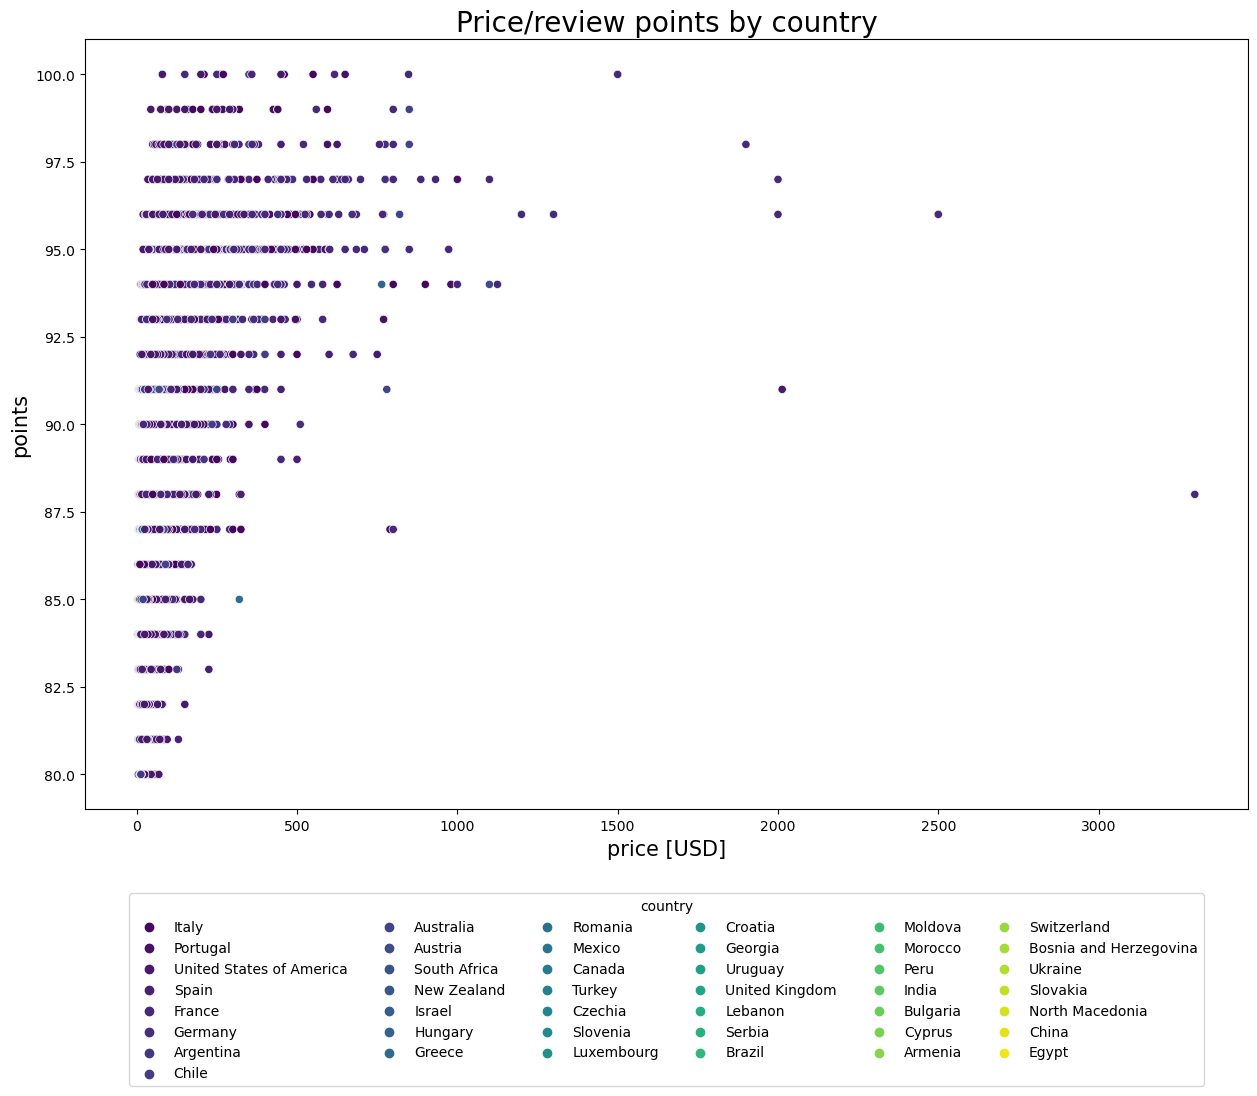

In [26]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x='price', y='points', hue='country', data=df_wine1, palette='viridis')
plt.title("Price/review points by country", fontsize=20)
plt.xlabel("price [USD]", fontsize=15)
plt.ylabel("points", fontsize=15)
plt.legend(title="country", loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
plt.show()

One can clearly see the couple of outliers at the right half of the chart

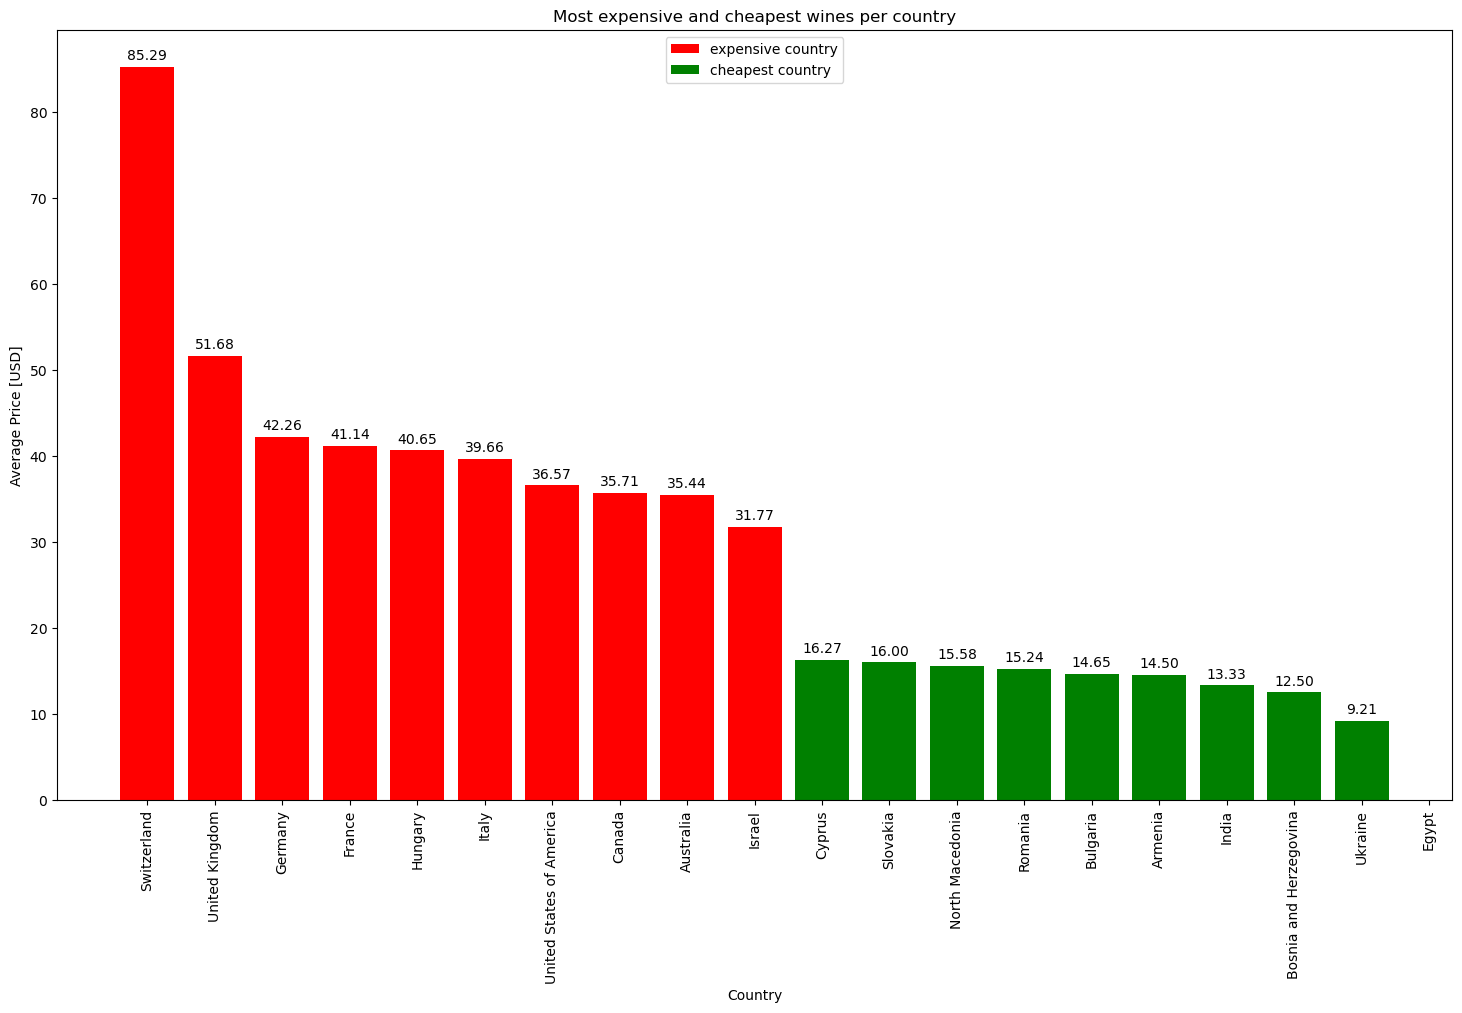

In [27]:
filtered_data = df_wine1[['country', 'price']]

average_price_by_country = filtered_data.groupby('country')['price'].mean()

sorted_countries = average_price_by_country.sort_values(ascending=False)

top_10_expensive = sorted_countries.head(10)
top_10_cheapest = sorted_countries.tail(10)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, color='black')
plt.figure(figsize=(18, 10))
autolabel(plt.bar(top_10_expensive.index, top_10_expensive.values, color='red', label='expensive country'))
autolabel(plt.bar(top_10_cheapest.index, top_10_cheapest.values, color='green', label='cheapest country'))
plt.xlabel('Country')
plt.ylabel('Average Price [USD]')
plt.title('Most expensive and cheapest wines per country')
plt.legend()
plt.xticks(rotation=90)
plt.show()

This is a very important graph. Switzerland appears to have by far the highest average price in this dataset, while Egypt has the lowest. However, it's important to consider the previously discussed number of entries per country in this analysis.

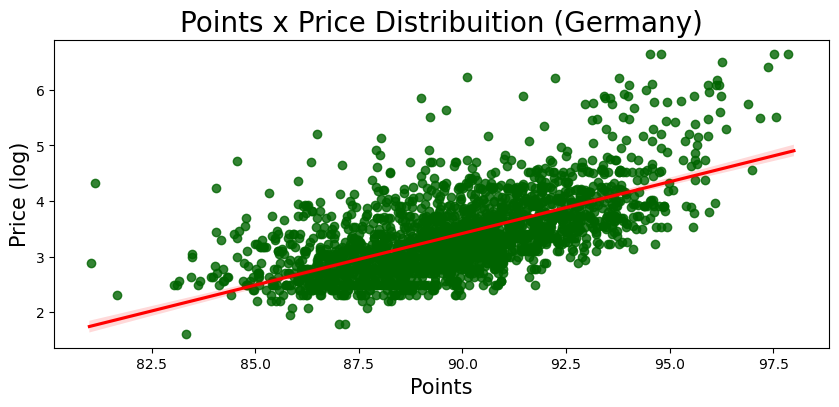

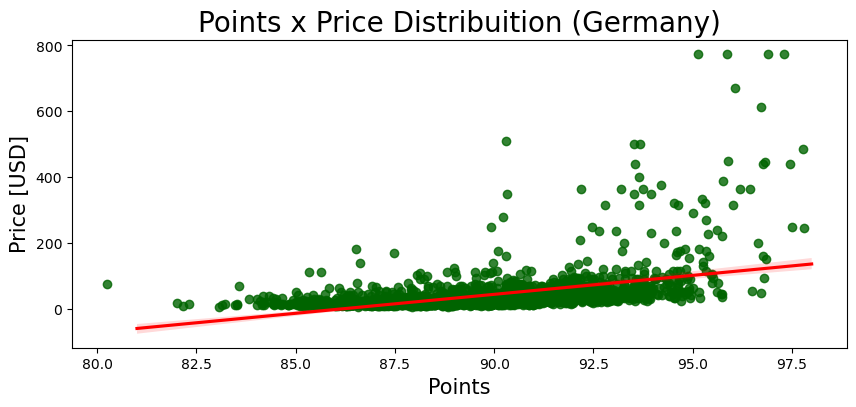

In [28]:
df_pricelog = df_wine1
df_pricelog['price_log'] = np.log(df_pricelog['price'])

filt_Ge = df_pricelog["country"] == "Germany"

plt.figure(figsize=(10,4))

g = sns.regplot(x='points', y='price_log', 
                data=df_pricelog[filt_Ge], line_kws={'color':'red'},
                x_jitter=True, fit_reg=True, color='darkgreen')
g.set_title("Points x Price Distribuition (Germany)", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price (log)", fontsize= 15)

plt.show()

filt_Ge = df_wine1["country"] == "Germany"

plt.figure(figsize=(10,4))

g = sns.regplot(x='points', y='price', 
                data=df_wine1[filt_Ge], line_kws={'color':'red'},
                x_jitter=True, fit_reg=True, color='darkgreen')
g.set_title("Points x Price Distribuition (Germany)", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price [USD]", fontsize= 15)

plt.show()

In the first plot the price is shown logarithmic. For the following analysis we will continue the points x price distribution without logarithm so we can actually quantify the results

In [29]:
#Creating a list of every country in the dataset
Countries = []
for land in df_wine1['country'].unique():
    Countries.append(land)
#there are nan values in Countries
cleanlist = []
for country in Countries:
    if type(country) == type("x"):
        cleanlist.append(country)
print(cleanlist)

['Italy', 'Portugal', 'United States of America', 'Spain', 'France', 'Germany', 'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa', 'New Zealand', 'Israel', 'Hungary', 'Greece', 'Romania', 'Mexico', 'Canada', 'Turkey', 'Czechia', 'Slovenia', 'Luxembourg', 'Croatia', 'Georgia', 'Uruguay', 'United Kingdom', 'Lebanon', 'Serbia', 'Brazil', 'Moldova', 'Morocco', 'Peru', 'India', 'Bulgaria', 'Cyprus', 'Armenia', 'Switzerland', 'Bosnia and Herzegovina', 'Ukraine', 'Slovakia', 'North Macedonia', 'China', 'Egypt']


Now we have clean list of every country in the dataset which has actally values

In [36]:
#Creating a dictionary for the slopes of each country
Slope = {}

for Country in cleanlist:
    filt = df_wine1["country"] == Country

    plt.figure(figsize=(10,4))

    g = sns.regplot(x='points', y='price', data=df_wine1[filt], line_kws={'color':'red'},
                        x_jitter=True, fit_reg=True, color='darkgreen')
    g.set_title("Points x Price Distribuition", fontsize=20)
    g.set_xlabel("Points", fontsize= 15)
    g.set_ylabel("Price", fontsize= 15)
    

    try:
        slope, intercept, r, p, sterr = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
        Slope[Country] = Slope.get(Country, slope)
    except:
        pass
    plt.close()
print(Slope)

{'Italy': 7.552085911281582, 'Portugal': 6.008455338817511, 'United States of America': 3.9377851256089182, 'Spain': 5.3175928587393635, 'France': 9.93630064143265, 'Germany': 11.515506613985087, 'Argentina': 4.181243723246053, 'Chile': 3.900409444173919, 'Australia': 7.630469501226528, 'Austria': 4.343500873099224, 'South Africa': 5.273047187341252, 'New Zealand': 3.3981703177595075, 'Israel': 2.6346818513149426, 'Hungary': 8.930421533773497, 'Greece': 0.742795743621217, 'Romania': 1.7799315849486814, 'Mexico': 3.0757626550452546, 'Canada': 2.613864661980376, 'Turkey': 1.6612490401842834, 'Czechia': 3.8837209302325912, 'Slovenia': 3.578614472832327, 'Luxembourg': -2.2000000000000837, 'Croatia': 2.0280774233034875, 'Georgia': 0.14030834868611955, 'Uruguay': 2.5078420767982683, 'United Kingdom': 2.2705301784132623, 'Lebanon': 2.0358846487424045, 'Serbia': 5.210526315789487, 'Brazil': 1.2990460070780074, 'Moldova': 2.256014774882701, 'Morocco': 0.05204460966542681, 'Peru': 2.395908543922

/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_42421/342191817.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


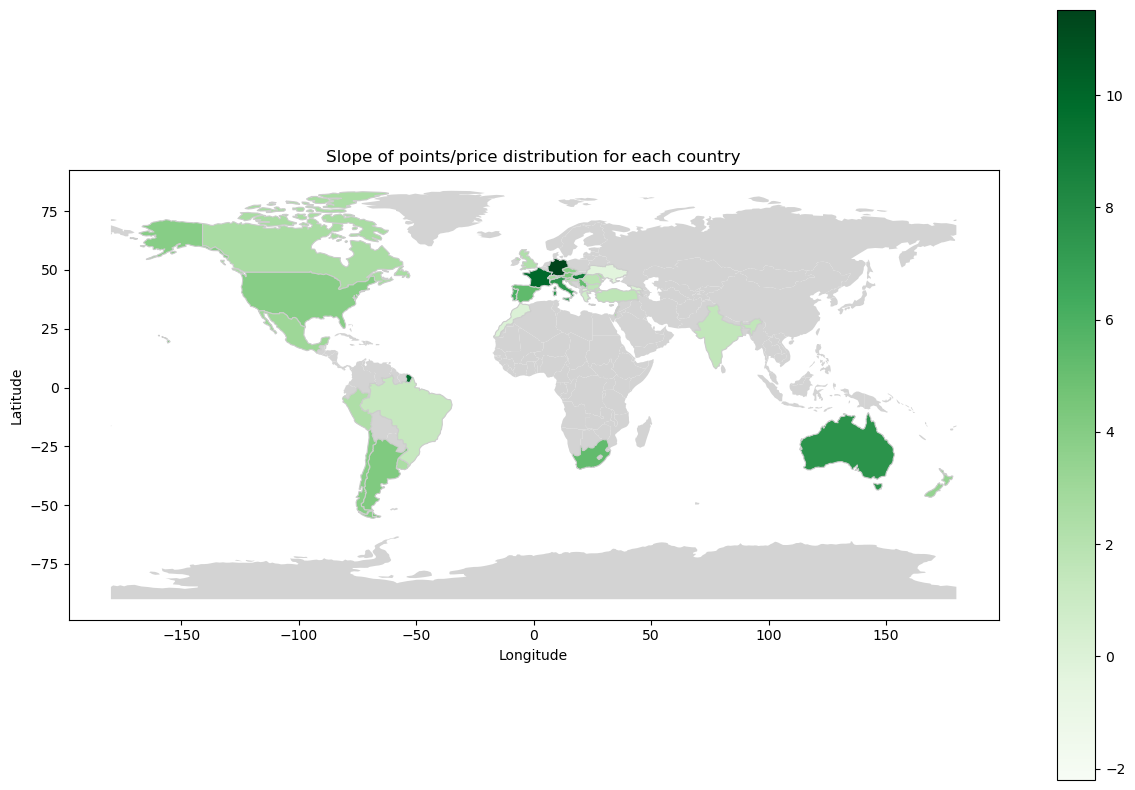

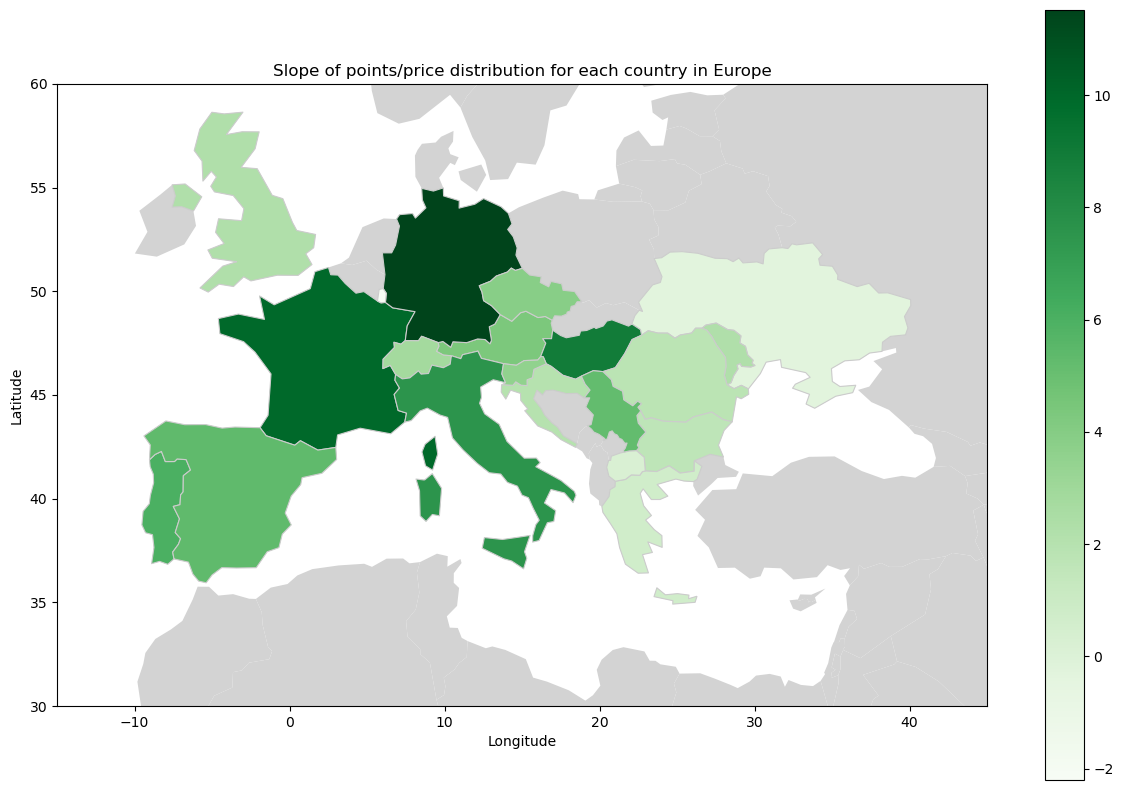

In [37]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

merged = world.set_index('name').join(pd.DataFrame(Slope.items(), columns=['name', 'value']).set_index('name'))
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
merged.plot(column='value', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Slope of points/price distribution for each country')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


europe = world[world['continent'] == 'Europe']

merged = europe.set_index('name').join(pd.DataFrame(Slope.items(), columns=['name', 'value']).set_index('name'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
merged.plot(column='value', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Slope of points/price distribution for each country in Europe')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

lat_min, lat_max = 30, 60
lon_min, lon_max = -15, 45

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

plt.show()

Thats interesting! To buy a higher quality wine in Germany, one must pay significantly more than in the UK, Switzerland or Eastern countries. However, this does not imply that high-quality wines are cheap in these countries. To dispel this confusion, the average price must be considered.

/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_42421/2062377899.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_42421/2062377899.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged['new_value']):


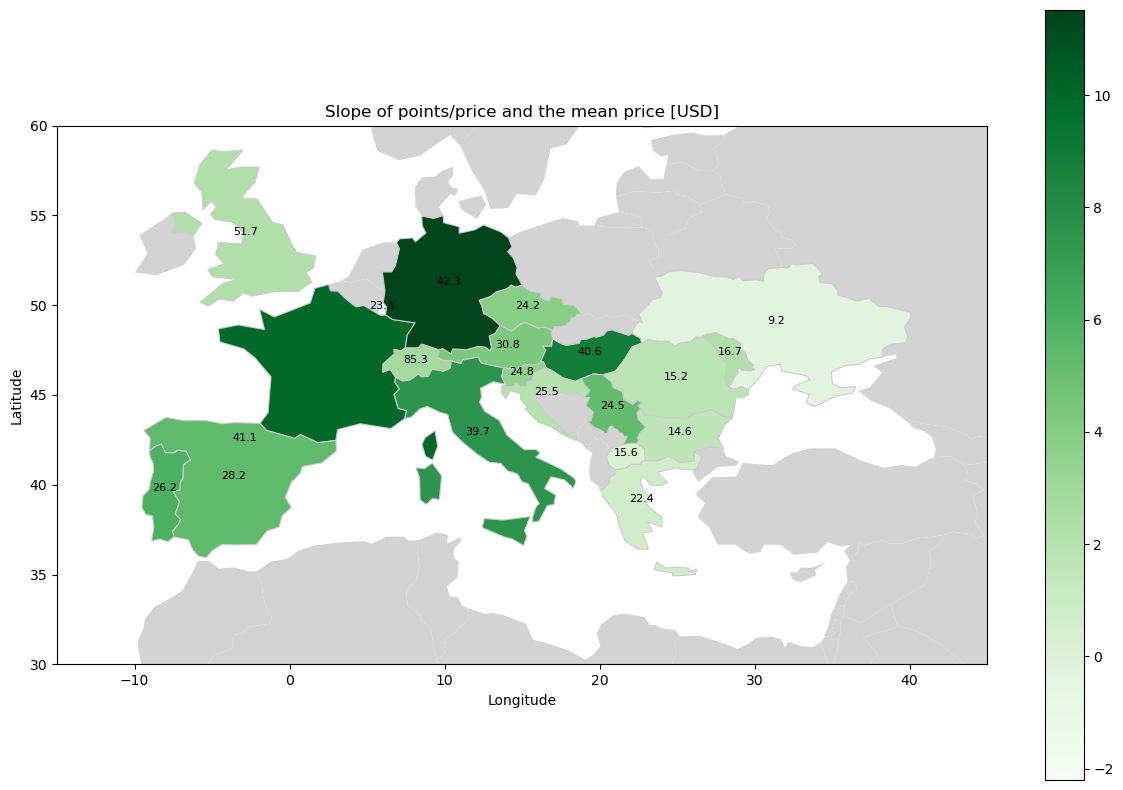

In [38]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

merged = europe.set_index('name').join(pd.DataFrame(Slope.items(), columns=['name', 'value']).set_index('name'))

merged['new_value'] = sorted_countries.round(1)
merged = merged.dropna(subset=['value'])

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
merged.plot(column='value', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Slope of points/price and the mean price [USD]')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged['new_value']):
    ax.text(x, y, str(label), fontsize=8, ha='center')

lat_min, lat_max = 30, 60
lon_min, lon_max = -15, 45
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
plt.show()

Wow! As we can see, both the UK and especially Switzerland have a very high average. Consequently, this average doesn't change as much for higher quality wines. The Balkan countries exhibit both a low average and a modest price increase for better wines. In this regard, Luxembourg stands out as the most attractive country.

Finally, we can determine both extremes: the best wine with the lowest price and the lowest-quality wine with the highest price. In other words, the wines with the best and worst value for money.

In [39]:
df_wine1.dropna(subset=["points", "price"], inplace=True)
filtered_df_top = df_wine1[df_wine1["points"] >= 95]

sorted_wines = filtered_df_top.sort_values(by="price", ascending=True)

display(sorted_wines.head(5))

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,price_log
15196,France,"The home vineyard of Madiran's star, Alain Bru...",Château Bouscassé,95,20.0,Southwest France,Madiran,NaN,Roger Voss,@vossroger,Alain Brumont 2010 Château Bouscassé Red (Madi...,Red Blend,Alain Brumont,2.995732
101580,United States of America,"Superb fruit highlights this tight, sculpted S...",NaN,96,20.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Rulo 2007 Syrah (Columbia Valley (WA)),Syrah,Rulo,2.995732
76570,United States of America,Spectacular is the word that comes to mind her...,Bacchus Vineyard,95,20.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Januik 2012 Bacchus Vineyard Riesling (Columbi...,Riesling,Januik,2.995732
5011,United States of America,"Truly stunning, the Lewis Estate Riesling from...",Lewis Estate Vineyard,95,20.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Dunham 2010 Lewis Estate Vineyard Riesling (Co...,Riesling,Dunham,2.995732
126242,United States of America,"With residual sugar at about 1.35%, this balan...",NaN,95,20.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Poet's Leap 2009 Riesling (Columbia Valley (WA)),Riesling,Poet's Leap,2.995732


Due to the high number of entries from the United States, it's hardly surprising that four out of the five best wines come from the USA. However, the best wine is a Chateau from France.

In [40]:

df_wine1.dropna(subset=["points", "price"], inplace=True)
filtered_df_bottom = df_wine1[df_wine1["points"] <= 80]

sorted_wines = filtered_df_bottom.sort_values(by="price", ascending=False)

display(sorted_wines.head(5))

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,price_log
103989,United States of America,This suffers from major problems. It has all t...,Miljenko's Old Vines,80,69.0,California,Napa Valley,Napa,NaN,NaN,Grgich Hills 2004 Miljenko's Old Vines Zinfand...,Zinfandel,Grgich Hills,4.234107
28569,United States of America,Smells and tastes like caramel and stewed cher...,Scoprire,80,55.0,California,California,California Other,NaN,NaN,Millésimé 2005 Scoprire Red (California),Red Blend,Millésimé,4.007333
65350,United States of America,"Blended from Syrah, Mourvèdre and the two Cabe...",Scopire,80,45.0,California,Santa Ynez Valley,Central Coast,NaN,NaN,Millésimé 2008 Scopire Red (Santa Ynez Valley),Red Blend,Millésimé,3.806662
122417,United States of America,There's little going on in this wine beyond su...,DeLuz,80,45.0,California,California,California Other,NaN,NaN,Casa Tiene Vista NV DeLuz Red (California),Red Blend,Casa Tiene Vista,3.806662
107774,United States of America,"Way too high in alcohol, giving it the ripe, h...",Reserve,80,44.0,California,Paso Robles,Central Coast,NaN,NaN,Opolo 2011 Reserve Zinfandel (Paso Robles),Zinfandel,Opolo,3.784190


The wine with the worst value for money, like all five wines, originates from the USA and is Miljenko's Old Vines from California.

# Variety point Distribution

First, the wine selection is illustrated using a word cloud.

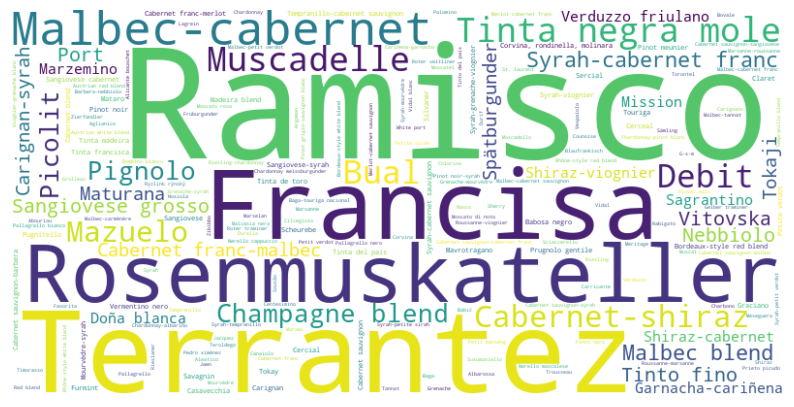

In [41]:
df_wine1_filtered = df_wine1[df_wine1['price'].notnull()]
wine_prices = df_wine1_filtered.groupby('variety')['price'].mean().reset_index()
wine_prices['variety'] = wine_prices['variety'].str.capitalize()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(wine_prices['variety'], wine_prices['price'])))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Bubble chart
variety_counts = wine_prices['variety'].value_counts()

Ramisco, Terrantez and Francisa stand out prominently.

In [42]:
sorted_europe = europe_with_mean_points.sort_values(by='points', ascending=False)

Next, we generate a word cloud for the 'description' column to uncover the most common descriptors of wine taste. By filtering out unnecessary words that don't accurately describe wine features but are popular in the visualization, we aim to produce a more informative chart highlighting attributes that describe high-quality wine

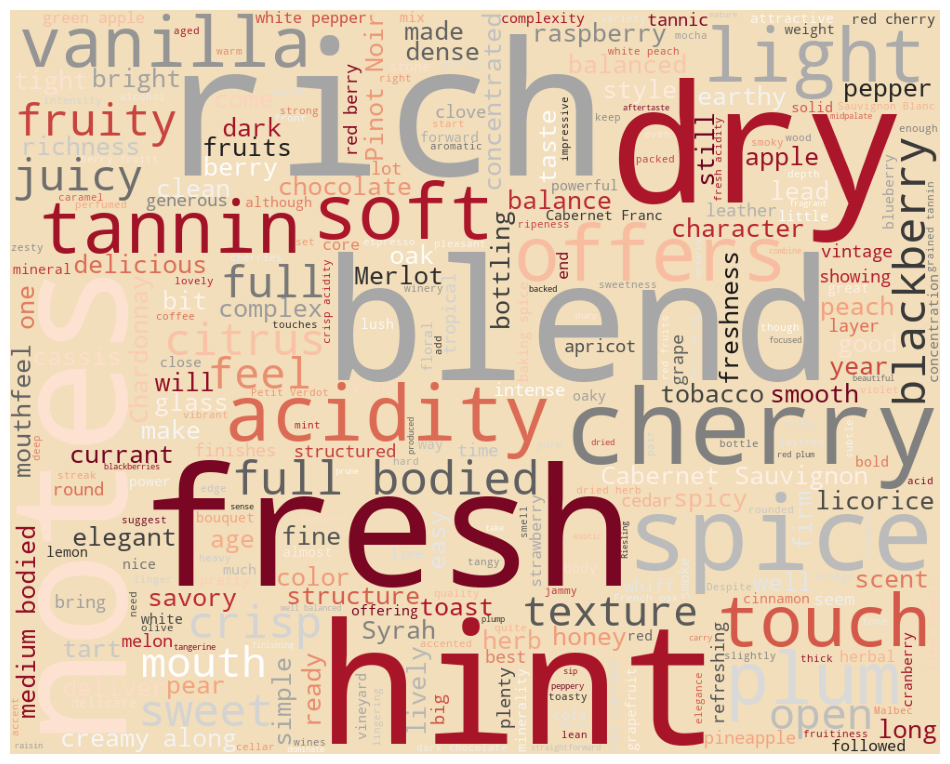

In [43]:
stopwords = set(STOPWORDS)

newStopWords = ['fruit', "note", "Drink", "black", 'wine', 'drink', 'finish', 'nose', 'show', 'now', 'ripe', 'aroma', 'flavor', 'flavors', 'palate', 'aromas', 'give', 'gives', 'shows', 'ofter', 'yet', 'offer']

stopwords.update(newStopWords)

wordcloud = WordCloud(
    colormap='RdGy',
    background_color='#F2DEBA',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df_wine1['description'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

From this, we can discern the most commonly used words to describe a wine in general.

Following this initial examination, we generate similar word clouds for wines rated >= 95 points (considered the best wines in the dataset) and those rated between 80 and 85 points (considered the worst wines in the dataset).

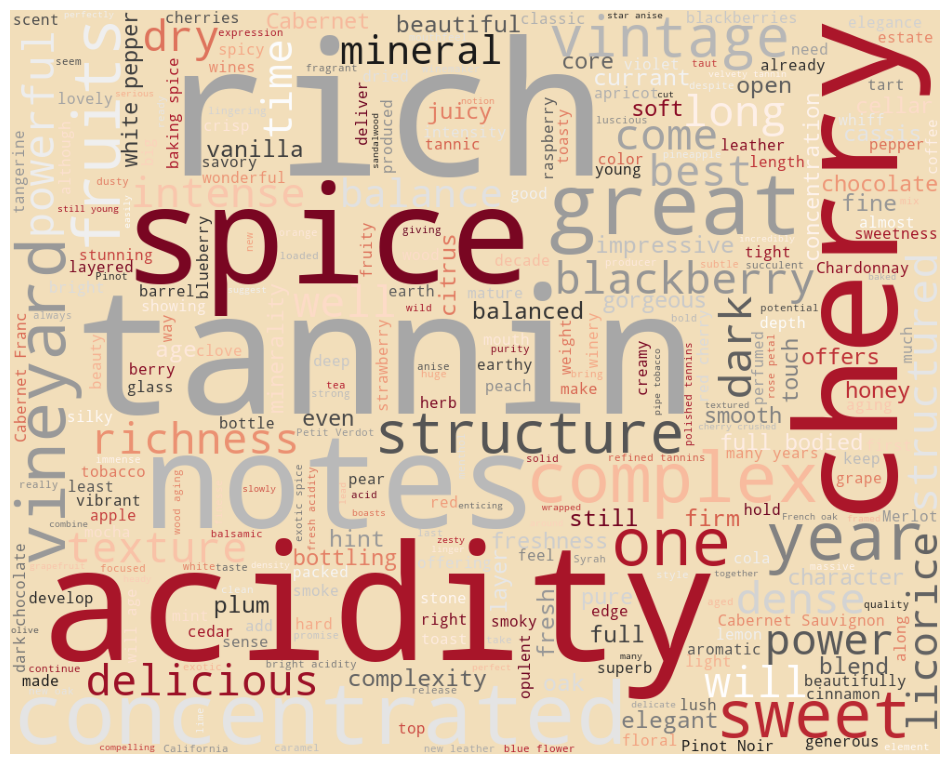

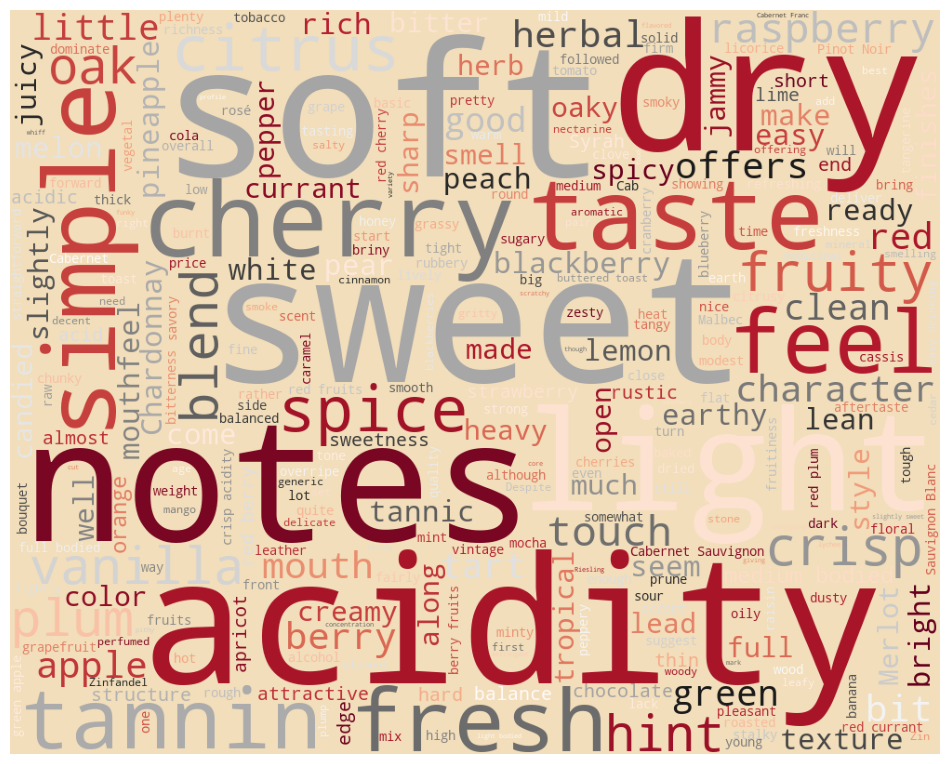

In [44]:
filtered_df = df_wine1[df_wine1['points'] >= 95]

filtered_df1 = df_wine1[(df_wine1['points'] >= 80) & (df_wine1['points'] <= 85)]

stopwords = set(STOPWORDS)

newStopWords = ['fruit', "note", "Drink", "black", 'wine', 'drink', 'finish', 'nose', 'show', 'now', 'ripe', 'aroma', 'flavor', 'flavors', 'palate', 'aromas', 'give', 'gives', 'shows', 'ofter', 'yet', 'offer']

stopwords.update(newStopWords)

wordcloud = WordCloud(
    colormap='RdGy',
    background_color='#F2DEBA',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(filtered_df['description'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

stopwords.update(newStopWords)

wordcloud = WordCloud(
    colormap='RdGy',
    background_color='#F2DEBA',
    stopwords=stopwords,
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(filtered_df1['description'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

When comparing these two charts, it becomes evident that good wines are described with terms like tannin, concentrated, and spice, while lower-quality wines are described with terms like soft, sweet, and simple.

The following code calculates the average points for each wine variety. After sorting, it generates output showcasing the best wine varieties and their respective countries of origin.

In [45]:
mean_points_per_variety = df_wine1.groupby('variety')['points'].mean().round(2)
mean_points_sorted = mean_points_per_variety.sort_values(ascending=False)
mean_points_top30 = mean_points_sorted.head(30)
display(mean_points_top30)

variety
Terrantez                    95.00
Tinta del Pais               95.00
Gelber Traminer              95.00
Bual                         94.33
Riesling-Chardonnay          94.00
Sercial                      94.00
Garnacha-Cariñena            93.00
Ramisco                      93.00
Blauburgunder                93.00
Roviello                     93.00
Muscadelle                   92.50
Sirica                       92.50
Vespaiolo                    92.00
Centesimino                  92.00
Torontel                     92.00
Sauvignon Blanc-Assyrtiko    92.00
Rosenmuskateller             92.00
Caprettone                   92.00
Chardonnay Weissburgunder    92.00
Babosa Negro                 92.00
Pignolo                      92.00
Tinta Negra Mole             92.00
Moscato di Noto              92.00
White Port                   92.00
Kotsifali                    92.00
Malbec-Cabernet              91.67
Chardonnay-Albariño          91.50
Picolit                      91.50
Syrah-Petit 

In [46]:
mean_points_per_variety_country = df_wine1.groupby(['variety', 'country'])['points'].mean().reset_index()
mean_points_per_variety = mean_points_per_variety_country.groupby('variety')['points'].mean()

top_varieties = mean_points_per_variety.nlargest(10).index
top_varieties_df = mean_points_per_variety_country[mean_points_per_variety_country['variety'].isin(top_varieties)]

pivot_table = top_varieties_df.pivot_table(index='variety', columns='country', values='points', fill_value=0)
pivot_table_sorted = pivot_table.loc[pivot_table.mean(axis=1).sort_values(ascending=False).index]

display(pivot_table_sorted)

country,Austria,Italy,Portugal,Spain,United States of America
variety,,,,,
Gelber Traminer,95.0,0.0,0.000000,0.0,0.0
Terrantez,0.0,0.0,95.000000,0.0,0.0
Tinta del Pais,0.0,0.0,0.000000,95.0,0.0
Bual,0.0,0.0,94.333333,0.0,0.0
Riesling-Chardonnay,0.0,0.0,0.000000,0.0,94.0
Sercial,0.0,0.0,94.000000,0.0,0.0
Blauburgunder,93.0,0.0,0.000000,0.0,0.0
Garnacha-Cariñena,0.0,0.0,0.000000,93.0,0.0
Ramisco,0.0,0.0,93.000000,0.0,0.0


In conclusion, this data science project has provided valuable insights into the characteristics of high-quality wines. By analyzing various attributes and employing visualization techniques, we have identified key factors that differentiate top-rated wines from lower-rated ones. This understanding can inform producers, retailers, and consumers alike, contributing to informed decision-making in the wine industry.

Moving forward, we aim to further explore predictions on the connection between price, taste, and rating of wines, leveraging the knowledge and insights gained from this analysis.